In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
import pandas as pd
import torch
torch.cuda.empty_cache()

In [8]:
rows=[]
with open('train_10k.txt','r') as f:
     l=f.readlines()
for text in l:
      text = text.strip()
      if text.startswith("__label__"):
          text = min(text[len("__label__"):],text[len("__label__"):128])
      lang, sent = text.split(" ", 1)
      rows.append([lang,sent])
df=pd.DataFrame(rows,columns=['lang','sent'])



In [9]:
df

,lang,sent
0,Hindi,aisee bachat hamein una sthitiyon mein bhee sa...
1,Malayalam,kramanugathamaayi eee alavu kootti 15 varsham ...
2,Sindhi,mislan : musjid nabvi jee qareeb hikk board te...
3,Telugu,haikortu nambaru prakaram :
4,Konkani,samajik samatayechyo baryoch ghoshana karoon l...
...,...,...
9995,Gujarati,kensarnaa rogeene raatre sutaa samaye
9996,Hindi,sarkaar reserve baink parr iss baat key liye b...
9997,Marathi,pahile aadivasi dhangar sahitya sammelan solap...
9998,Gujarati,aaa banne mato maane chhe keey ee . saes . 132...


In [10]:
df.shape

(10000, 2)

In [11]:
df.sample(10)

,lang,sent
7531,Maithili,"< br / > saahas sae jeete sabhee , dekh chukaa..."
974,Other,Vi sono evidenze - è scritto nella circolare -...
37,Manipuri_Mei,astatin
5826,Punjabi,"2012 witch iss khetar witch kull 102,402 votar..."
6967,English,""" Cavinton "" or "" Mexidol "" : what is better ?"
4154,Marathi,pantoji shalemadhye teey hote .
3888,Tamil,"nagaththil vedippu , adhan valaivugal , pullig..."
1310,Manipuri_Mei,"laaknage , haiyu imaada ꫱” < br >"
3463,Manipuri_Mei,365
7979,Marathi,swachchh maharashtra abhiyan ( nagri ) chaa pr...


In [12]:
sentences=df.sent.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.lang.values

In [13]:
sentences[:5]

['[CLS] aisee bachat hamein una sthitiyon mein bhee sahaayata karati haye , jaba humm kamai karane mein saksham naheen hotey hain , udaaharan key liye sevaanivritti key baad . [SEP]',
 '[CLS] kramanugathamaayi eee alavu kootti 15 varsham ( praayapoortthi ) aakumbol oro maratthinum 50 kiloo pachila / compoost / jaiva valangalil eathenkilum onnum 500:250:100 gram kanakkil raasavalavum nalkanam . [SEP]',
 '[CLS] mislan : musjid nabvi jee qareeb hikk board tee likhyal dithham : [SEP]',
 '[CLS] haikortu nambaru prakaram : [SEP]',
 '[CLS] samajik samatayechyo baryoch ghoshana karoon legeet hyaa deshant nigro khaatir jaay tashe hakk hanga naat . [SEP]']

In [14]:
labels[:5]

array(['Hindi', 'Malayalam', 'Sindhi', 'Telugu', 'Konkani'], dtype=object)

In [15]:
# Encode to integers
label_encoder = LabelEncoder()
labels= label_encoder.fit_transform(labels)
num_labels = len(label_encoder.classes_)


In [16]:
num_labels

22

In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 358263.67B/s]


Tokenize the first sentence:
['[CLS]', 'ai', '##see', 'bach', '##at', 'ham', '##ein', 'una', 'st', '##hiti', '##yon', 'mein', 'b', '##hee', 'sa', '##ha', '##aya', '##ta', 'kara', '##ti', 'hay', '##e', ',', 'ja', '##ba', 'hum', '##m', 'kam', '##ai', 'kara', '##ne', 'mein', 'sa', '##ksha', '##m', 'nah', '##een', 'hot', '##ey', 'hai', '##n', ',', 'ud', '##aa', '##hara', '##n', 'key', 'li', '##ye', 'se', '##va', '##ani', '##vr', '##itt', '##i', 'key', 'ba', '##ad', '.', '[SEP]']


In [18]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [19]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [20]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [21]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [22]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [23]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [24]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [25]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [26]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

100%|██████████| 407873900/407873900 [00:33<00:00, 12218140.30B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [27]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [28]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [29]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import torch
torch.cuda.empty_cache()

In [31]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.2116666242215368


Epoch:  50%|█████     | 1/2 [16:59<16:59, 1019.58s/it]

Validation Accuracy: 0.826
Train loss: 0.367535672650569


Epoch: 100%|██████████| 2/2 [33:57<00:00, 1018.98s/it]

Validation Accuracy: 0.884


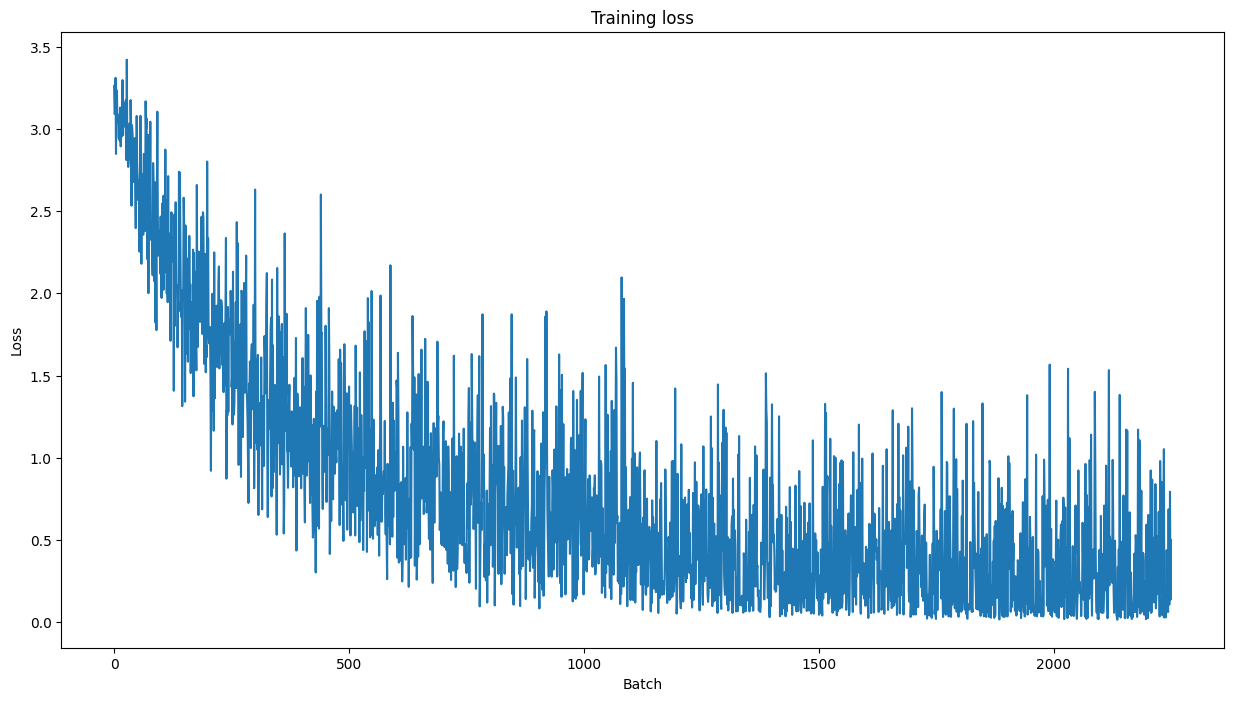

In [32]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [34]:
rows=[]
with open('val_1k.txt','r') as f:
     l=f.readlines()
for text in l:
      text = text.strip()
      if text.startswith("__label__"):
          text = min(text[len("__label__"):],text[len("__label__"):512])
      lang, sent = text.split(" ", 1)
      rows.append([lang,sent])
df2=pd.DataFrame(rows,columns=['lang','sent'])

sentences=df.sent.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.lang.values
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
label_encoder = LabelEncoder()
labels= label_encoder.fit_transform(labels)
num_labels = len(label_encoder.classes_)


MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [35]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [36]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [39]:
matthews_set

[np.float64(0.935214721648971),
 np.float64(0.9669597516300409),
 np.float64(0.9007896044148774),
 np.float64(0.934265518882863),
 np.float64(1.0),
 np.float64(0.9675052410901468),
 np.float64(0.8692002465799947),
 np.float64(0.9668094218415417),
 np.float64(0.9343920575528788),
 np.float64(0.9331941544885177),
 np.float64(1.0),
 np.float64(0.9330504737259959),
 np.float64(0.9336946456995847),
 np.float64(1.0),
 np.float64(0.9350187011133578),
 np.float64(0.9664915695818846),
 np.float64(0.9354544492658411),
 np.float64(0.8379244477093728),
 np.float64(0.9676751871983059),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.9352818371607515),
 np.float64(0.9353498307293969),
 np.float64(0.9669162390223995),
 np.float64(0.9674759374246503),
 np.float64(0.9021052631578947),
 np.float64(0.9019007412935625),
 np.float64(0.9672995780590717),
 np.float64(0.9017956453357943),
 np.float64(0.934530616068124),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.9004282655246253),
 np.float64(0.93383

In [37]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [38]:
matthews_corrcoef(flat_true_labels, flat_predictions)

np.float64(0.950192339534139)